In [1]:
import numpy as np
from pysr import PySRRegressor
import matplotlib.pyplot as plt
import os
import esr.generation.generator
import pandas as pd
import string
import sympy
import jax
import jax.numpy as jnp
import itertools

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.


In [2]:
n_components = 2

Load data

In [3]:
pwd

'/Users/lucas/repositories/degen_discovery/symbolic_regression'

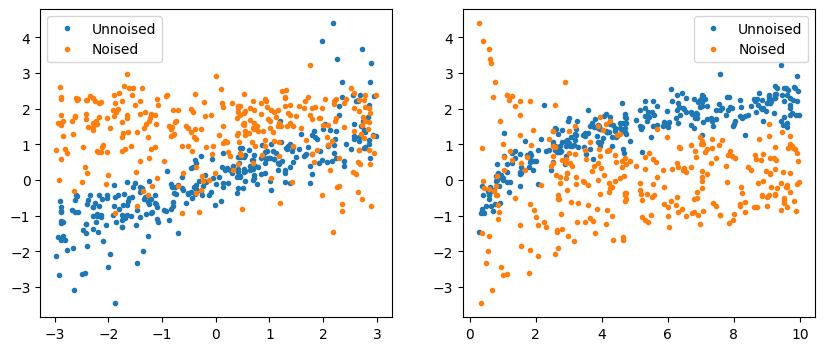

In [55]:
# generate some fake data and noise ("true" flattening coordinates)

np.random.seed(0)
nsamp = 300

def eta(X):
    return jnp.stack([X[:, 0] / jnp.sqrt(X[:, 1]), jnp.log(X[:, 1])]).T
    
    
def eta_jax(X):
    return jnp.array([X[0] / jnp.sqrt(X[1]), jnp.log(X[1])])

def onejac(fn, X):
    return jax.jacrev(fn)(X)


# generate data and some gradient with error
mu = np.random.uniform(low=-3.0, high=3.0, size=nsamp)
var = np.random.uniform(low=0.25, high=10, size=nsamp)
X = np.stack([mu, var], -1)
y = eta(X)

sigy = np.random.uniform(0.2, 0.5, size=y.shape)
y = y + sigy * np.random.normal(size=y.shape)


myjac = lambda x: onejac(eta_jax, x)
dy = jax.vmap(myjac)(X)
dJ = np.random.uniform(0.1, 0.25, size=(dy.shape))

dy += deltaJ *  np.random.normal(size=dy.shape)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(X[:,0], y[:, 0], '.', label='Unnoised')
axs[1].plot(X[:,1], y[:, 1], '.', label='Unnoised')
axs[0].plot(X[:,0], y[:, 1], '.', label='Noised')
axs[1].plot(X[:,1], y[:, 0], '.', label='Noised')
for ax in axs:
    ax.legend()


In [15]:
y.shape

In [16]:
X.shape

In [5]:
X[:, 0].min()

-4.998583

Run PySR with Gaussian loss function

In [56]:
eq_file = 'multi_component/test_multi_comp.csv'

In [57]:
pysr_args = dict(
    binary_operators=["+", "*", "/"],
    unary_operators=[
        "sqrt",
        "exp",
        "log",
        #"sin",
       # "inv(x) = 1/x",
    ],
    #extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
)
model = PySRRegressor(
    niterations=100,  # < Increase me for better results
    equation_file=eq_file,
    **pysr_args,
)
model.fit(X, y) #, weights=sigy)

/Users/lucas/venvs/pysr/lib/python3.10/site-packages/pysr/sr.py:1309: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(



Expressions evaluated per second: 3.570e+05
Head worker occupation: 14.1%
Progress: 791 / 3000 total iterations (26.367%)
Best equations for output 1
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.529e+00  1.594e+01  y₀ = 0.55828
2           1.312e+00  1.527e-01  y₀ = exp(-1.4567)
3           3.410e-01  1.348e+00  y₀ = x₀ / x₁
4           1.114e-01  1.119e+00  y₀ = x₀ / sqrt(x₁)
6           1.104e-01  4.636e-03  y₀ = (x₀ / sqrt(x₁)) + 0.032032
8           1.098e-01  2.542e-03  y₀ = (x₀ / sqrt(x₁)) + (0.0068447 * x₁)
9           1.077e-01  1.950e-02  y₀ = (exp(x₁) * 1.0579e-05) + (x₀ / sqrt(x₁))
11          1.077e-01  1.252e-06  y₀ = ((exp(x₁) + x₀) * 1.0579e-05) + (x₀ / sqrt(x₁))
13          1.077e-01  1.109e-05  y₀ = (x₀ / sqrt(x₁)) + (exp(log(exp(x₁)) + 0.088389) * 1.0579e...
                                  -05)
19          1.077e-01  1.754e-05  y₀ = (0.008641

[ Info: Started!


PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                          0.5582826   
	1         0.174983                                  sqrt(0.003997356)   
	2         1.325221                                            x0 / x1   
	3   >>>>  1.118646                                      x0 / sqrt(x1)   
	4         0.004636                      (x0 / sqrt(x1)) + 0.032031834   
	5         0.002542               (x1 * 0.006832982) + (x0 / sqrt(x1))   
	6         0.019584         (exp(x1) * 1.1095217e-5) + (x0 / sqrt(x1))   
	7         0.000662  (exp(x1) * 1.1095217e-5) + (x0 / sqrt(x1 * 0.9...   
	8         0.001793  (-0.020590214 / (x1 + log(sqrt(x1)))) + (x0 / ...   
	9         0.000053  (-0.020590214 / (x1 + log(sqrt(x1 * 1.0017079)...   
	10        0.000023  (-0.020590214 / (x1 + log(sqrt((x1 * 1.0017079...   
	
	        loss  complexity  
	0   1.528680           1  
	1   1.283283           2  
	2   0.341025           3  
	3   0.111420           4  
	4   0.110392           6  
	5   0.109832           8  
	6   0.107702           9  
	7   0.107560          11  
	8   0.107367          12  
	9   0.107356          14  
	10  0.107351          16  
], [
	    pick     score                                           equation  \
	0         0.000000                                          1.9427975   
	1   >>>>  2.160271                                            log(x1)   
	2         0.005987                              log(x1 + 0.061670117)   
	3         0.004291                  log(x1 + 0.074121915) * 0.9796392   
	4         0.000886       log(x1) + (-0.010031223 / (x1 + -1.0671275))   
	5         0.007904   log(x1) + (-0.0017319875 / (exp(0.073754) + x0))   
	6         0.006594  log(x1) + ((-0.0017319875 / 0.40037456) / (exp...   
	7         0.005243         log(x1) + (sqrt(x1) / exp(x1 + (x0 * x0)))   
	8         0.002750   log(x1 / 1.0393587) + (x1 / exp(x1 + (x0 * x0)))   
	9         0.003820  log(x1 / 1.0393587) + (sqrt(x1) / exp(x1 + (x0...   
	10        0.000688  log(x1 / 1.0393587) + (sqrt(x1) / exp(x1 + ((x...   
	11        0.001856  log(x1) + (sqrt(x1) / exp(x1 + (((exp(x0) + -0...   
	12        0.000389  log(x1) + (exp(x0) / (exp(x1) + exp(((x0 + (sq...   
	
	        loss  complexity  
	0   1.044081           1  
	1   0.120376           2  
	2   0.118943           4  
	3   0.117927           6  
	4   0.117718           8  
	5   0.116791           9  
	6   0.115261          11  
	7   0.114658          12  
	8   0.114344          13  
	9   0.113908          14  
	10  0.113751          16  
	11  0.113540          17  
	12  0.113408          20  
]]

Load the functions from csv file

In [59]:
def split_by_punctuation(s):
    """
    Convert a string into a list, where the string is split by punctuation,
    excluding underscores or full stops.
    
    For example, the string 'he_ll*o.w0%rl^d' becomes
    ['he_ll', '*', 'o.w0', '%', 'rl', '^', 'd']
    
    Args:
        :s (str): The string to split up
        
    Returns
        :split_str (list[str]): The string split by punctuation
    
    """
    pun = string.punctuation.replace('_', '') # allow underscores in variable names
    pun = string.punctuation.replace('.', '') # allow full stops
    pun = pun + ' '
    where_pun = [i for i in range(len(s)) if s[i] in pun]
    if len(where_pun) > 0:
        split_str = [s[:where_pun[0]]]
        for i in range(len(where_pun)-1):
            split_str += [s[where_pun[i]]]
            split_str += [s[where_pun[i]+1:where_pun[i+1]]]
        split_str += [s[where_pun[-1]]]
        if where_pun[-1] != len(s) - 1:
            split_str += [s[where_pun[-1]+1:]]
    else:
        split_str = [s]
        
    # Remove spaces
    split_str = [s.strip() for s in split_str if len(s) > 0 and (not s.isspace())]
    
    return split_str

def is_float(s):
    """
    Function to determine whether a string has a numeric value
    
    Args:
        :s (str): The string of interest
        
    Returns:
        :bool: True if s has a numeric value, False otherwise
        
    """
    try:
        float(eval(s))
        return True
    except:
        return False

def replace_floats(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    split_str = split_by_punctuation(s)
    values = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:
            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(']):
            values[i] *= -1
            split_str[idx-1] = ''

    # Rejoin string
    replaced = ''.join(split_str)

    return replaced, values


def compute_DL(eq, idx):

    basis_functions = [["x", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos"],  # type1
            ["+", "*", "-", "/", "pow"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "pow": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                }
    
    expr, pars = replace_floats(eq)
    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )
    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'x{i}' for i in range(X.shape[1])])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])

    # print(len(all_b))
    # print(inspect.getfullargspec(eq_jax))
    # print(list(range(0, len(inspect.getfullargspec(eq_jax).args)))[len(all_b):])
    
    def myloss(p):
        ypred = eq_jax(*p, *X.T)

        #myeq = lambda x1,x2: eq_jax(*p, x1,x2)
        myeq = lambda *args: eq_jax(*p, *args)

        # THIS IS FOR A SINGLE COMPONENT
        yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
        Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T 
        
        # NEED TO TAKE SLICE OF NUMERICAL JACOBIAN
        return np.sum((dy[:, idx, :] - Jpred)**2 / 2 / dJ[:, idx, :]**2)

    
    neglogL = myloss(pars)
    all_logL[i] = neglogL
    
    if len(pars) == 0:
        param_codelen = 0
    else:
        theta_ML = np.array(pars)

        # Compute loss and Hessian
        hessian_myloss = jax.hessian(myloss)
        I_ii = np.diag(np.array(hessian_myloss(pars)))

        # Check the Hessian is valid
        if np.any(I_ii < 0):
            return c, latex_expr, neglogL, np.nan
            
        # Remove parameters which do not affect the likelihood or zero parameters
        kept_mask = (I_ii > 0) & (theta_ML != 0)
        theta_ML = theta_ML[kept_mask]
        I_ii = I_ii[kept_mask]
        
        # If the error is bigger than the parameter value, we can just set the
        # precision to the parameter value
        Delta = np.sqrt(12./I_ii)
        nsteps = np.abs(np.array(theta_ML))/Delta
        m = nsteps < 1
        I_ii[m] = 12 / theta_ML[m] ** 2
        
        # Compute parameter part of codelength
        p = len(theta_ML)
        param_codelen = -p/2.*np.log(3.) + np.sum( 0.5*np.log(I_ii) + np.log(abs(np.array(theta_ML))) )
    
    # Combine the terms
    DL = neglogL + aifeyn + param_codelen
    
    return c, latex_expr, neglogL, DL, 

In [47]:
dJ.shape

In [32]:
fname = eq_file[:-4]

fname

'multi_component/test_multi_comp'

In [36]:
len(hof)

In [38]:
data = pd.read_csv(fname + '.csv.out1')


In [41]:
data['Loss']

0     0.968175
1     0.341025
2     0.111420
3     0.110392
4     0.109832
5     0.107702
6     0.107556
7     0.107368
8     0.107045
9     0.106452
10    0.106401
11    0.106394
12    0.106382
13    0.106334
Name: Loss, dtype: float64

In [42]:
n_components

Checking if multi_component/test_multi_comp.pkl exists...
Loading model from multi_component/test_multi_comp.pkl
analysing 1 of 2 components
Best equation: x0 / sqrt(x1)


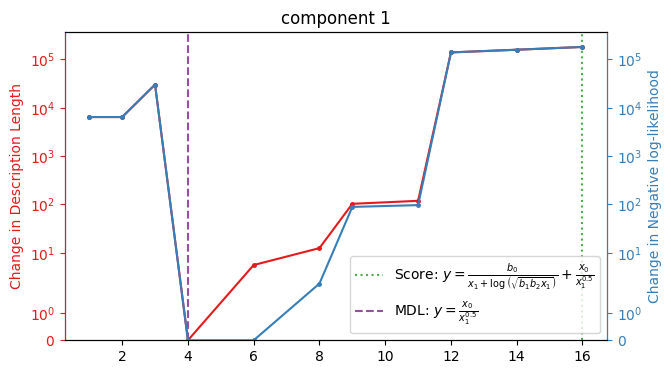

analysing 2 of 2 components
Best equation: log(x1)


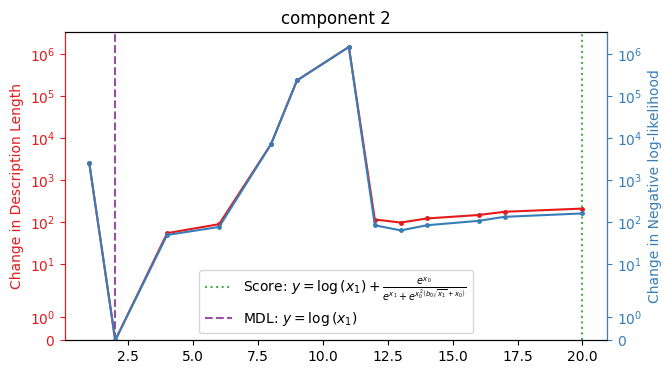

In [61]:
# Find what PySR got as the best one
if os.path.isfile(fname + '.pkl'):
    model = PySRRegressor.from_file(fname + '.pkl')
else:
    model = PySRRegressor.from_file(
        fname + '.csv',
        nout = 1,
        n_features_in=X.shape[1],
        **pysr_args
    )

for idx in range(n_components):

    print("analysing %d of %d components"%(idx+1, n_components))

    hof = model.get_hof()[idx]
    pysr_ibest = np.argmin(hof['score'][1:]) + 1
    
    # Find what description length (arXiv:2211.11461, Eq. 6) gives
    data = pd.read_csv(fname + '.csv.out%d'%(idx + 1))
    complexity = np.array(data["Complexity"])
    loss = np.array(data["Loss"])
    eqs = list(data['Equation'])
    
    all_DL = np.ones(len(eqs)) * np.inf
    all_logL = np.ones(len(eqs)) * np.inf
    all_latex = [None] * len(eqs)
    
    for i, eq in enumerate(eqs):
        c, all_latex[i], all_logL[i], all_DL[i] = compute_DL(eq, idx)
        
    # Only changes in DL and logL matter
    all_DL -= np.amin(all_DL)
    all_logL -= np.amin(all_logL)
    
    # Print the best found equation
    ibest = np.argmin(all_DL)
    print('Best equation:', eqs[ibest])
    
    fig, ax1 = plt.subplots(1, 1, figsize=(7,4), sharex=True)
    cm = plt.get_cmap('Set1')
    ax2 = ax1.twinx()
    ax1.plot(complexity, all_DL, marker='.', color=cm(0), markersize=5)
    ax2.plot(complexity, all_logL, marker='.', color=cm(1), markersize=5)
    
    ax1.set_ylabel('Change in Description Length')
    ax2.set_ylabel('Change in Negative log-likelihood')
    ax1.yaxis.label.set_color(cm(0))
    ax1.tick_params(axis='y', colors=cm(0))
    ax2.spines['left'].set_color(cm(0))
    
    ax2.yaxis.label.set_color(cm(1))
    ax2.tick_params(axis='y', colors=cm(1))
    ax2.spines['right'].set_color(cm(1))
    
    ax1.set_yscale('symlog')
    ax2.set_yscale('symlog')
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)
    
    ax1.axvline(complexity[pysr_ibest], color=cm(2), ls=':', label=r'Score: $y = %s$'%all_latex[pysr_ibest])
    ax1.axvline(complexity[ibest], color=cm(3), ls='--', label=r'MDL: $y = %s$'%all_latex[ibest])
    ax1.legend()
    plt.title("component %d"%(idx + 1))
    
    plt.show()
    #fig.savefig('function_ranking_flat.png', bbox_inches='tight', facecolor='white')


now write a function to test the Fishers of the found expressions over the prior